<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/home/elvira/Documents/Машинка/elka'  #'C:/Users/ivelk/Documents/6course'  #'/home/elvira/Documents/Машинка/'

In [3]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, '3users/user0001.csv'))
data.head(14)

,timestamp,site
0,2013-11-15 09:28:17,vk.com
1,2013-11-15 09:33:04,oracle.com
2,2013-11-15 09:52:48,oracle.com
3,2013-11-15 11:37:26,geo.mozilla.org
4,2013-11-15 11:40:32,oracle.com
5,2013-11-15 11:40:34,google.com
6,2013-11-15 11:40:35,accounts.google.com
7,2013-11-15 11:40:37,mail.google.com
8,2013-11-15 11:40:40,apis.google.com
9,2013-11-15 11:41:35,plus.google.com


In [32]:
data.timestamp = pd.to_datetime(data.timestamp)

In [35]:
data.timestamp.dt.month

0     11
1     11
2     11
3     11
4     11
5     11
6     11
7     11
8     11
9     11
10    11
11    11
12    11
13    11
Name: timestamp, dtype: int64

In [4]:
data.timestamp[1:10]

1    2013-11-15 09:33:04
2    2013-11-15 09:52:48
3    2013-11-15 11:37:26
4    2013-11-15 11:40:32
5    2013-11-15 11:40:34
6    2013-11-15 11:40:35
7    2013-11-15 11:40:37
8    2013-11-15 11:40:40
9    2013-11-15 11:41:35
Name: timestamp, dtype: object

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    if window_size < 1 or window_size > session_length:
        ValueError()
    else:
        file_list = sorted(glob(os.path.join(path_to_csv_files,'*.csv')))
        with open(site_freq_path, 'rb') as f:
            site_freq_dict = pickle.load(f)


        file_data = {}
        user_data = {}
        for user_id, file_name in enumerate(file_list):
            data = pd.read_csv(file_name)
            data.timestamp = pd.to_datetime(data.timestamp)
            
            hours = np.array(data.timestamp.dt.hour, dtype=np.int64)
            daysofweek = np.array(data.timestamp.dt.dayofweek, dtype=np.int64)
            all_time_diff = [int(pd.Timedelta(d2 - d1).seconds) for d1, d2 in zip(data.timestamp[:- 1], data.timestamp[1:])]
            site_id = np.array([site_freq_dict[site][0] for site in data.site])
            if window_size:
                axis0 = whole = len(site_id) // window_size
                rest = len(site_id) % window_size
                if rest:
                    axis0 += 1
                file_data[user_id] = np.zeros((axis0, len(feature_names)), dtype=np.int64)
                for i, shift in enumerate(range(0, len(site_id), window_size)):
                    if shift + session_length <= len(site_id):
                        
                        site_in_session = list(site_id[shift:(shift + session_length)])
                        time_diff = all_time_diff[shift:(shift + session_length) - 1]
                        hour = hours[shift:(shift + session_length)].min()
                        dayofweek = daysofweek[shift:(shift + session_length)].min()
                        
                        file_data[user_id][i] = site_in_session + time_diff + [sum(time_diff)] + [len(np.unique(site_in_session))] + [hour] + [dayofweek] + [user_id + 1]
                    else:
                        file_data[user_id][i][:rest] = site_id[shift:]
                        
                        time_diff = all_time_diff[shift:]
                        
                        file_data[user_id][i][session_length :(session_length + rest - 1)] = time_diff
                        file_data[user_id][i][-5:] = [sum(time_diff)] + [len(np.unique(site_id[shift:]))] + [hours[shift:].min()] + [daysofweek[shift:].min()] + [user_id + 1]
        
        file_len = len(file_list) - 1
        for i in range(file_len):
            file_data[i + 1] = np.vstack((file_data[i], file_data[i + 1]))
            
        user_data = pd.DataFrame(file_data[file_len], columns=feature_names, index=range(1, file_data[file_len].shape[0] + 1))
        user_data.index.name = 'session_id'

        return user_data

**Проверим функцию на игрушечном примере.**

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
session_id,,,,,,,,,,,,,,,,,,,,,,,,
1,4,2,2,11,2,1,10,6,9,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
2,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
3,4,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
4,3,1,2,1,2,1,1,6,7,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
5,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 5.09 s, sys: 48.5 ms, total: 5.14 s
Wall time: 5.18 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
session_id,,,,,,,,,,,,,,,,,,,,,,,,
1,193,587,134,3,134,134,3,134,204,134,10,0,0,1,20,1,0,1,0,33,5,8,4,1
2,425,192,706,257,134,31,401,4913,221,55,1,0,163,105,0,1,3,3,8,284,10,8,4,1
3,55,3,55,55,5,295,425,341,936,55,0,14,1,242,0,0,1,0,0,258,7,8,4,1
4,486,4912,486,55,55,55,55,1006,202,124,2,1,0,1,25,1,0,0,0,30,6,8,4,1
5,349,55,5,4911,261,212,4910,2574,705,2574,1,0,1,1,1,0,1,1,0,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 51 s, sys: 1.6 s, total: 52.6 s
Wall time: 50.7 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [13]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(new_features_10users['session_timespan'])

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [14]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(new_features_10users['day_of_week'])

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [15]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(new_features_150users['start_hour'])

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [16]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(new_features_150users['#unique_sites'])

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [17]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [18]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0.5,0,'Продолжительность сессии, сек')

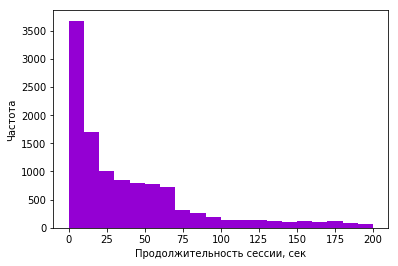

In [19]:
train_data_10users['session_timespan'][train_data_10users['session_timespan'] <= 200].plot(kind='hist', bins=20, color='darkviolet')
plt.ylabel('Частота')
plt.xlabel('Продолжительность сессии, сек')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0.5,0,'Число уникальных сайтов')

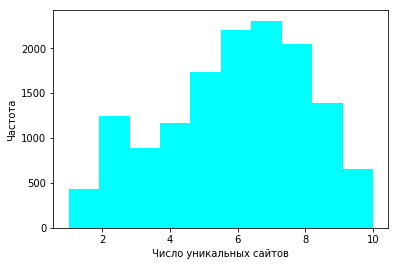

In [20]:
train_data_10users['#unique_sites'].plot(kind='hist', color='aqua')
plt.ylabel('Частота')
plt.xlabel('Число уникальных сайтов')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

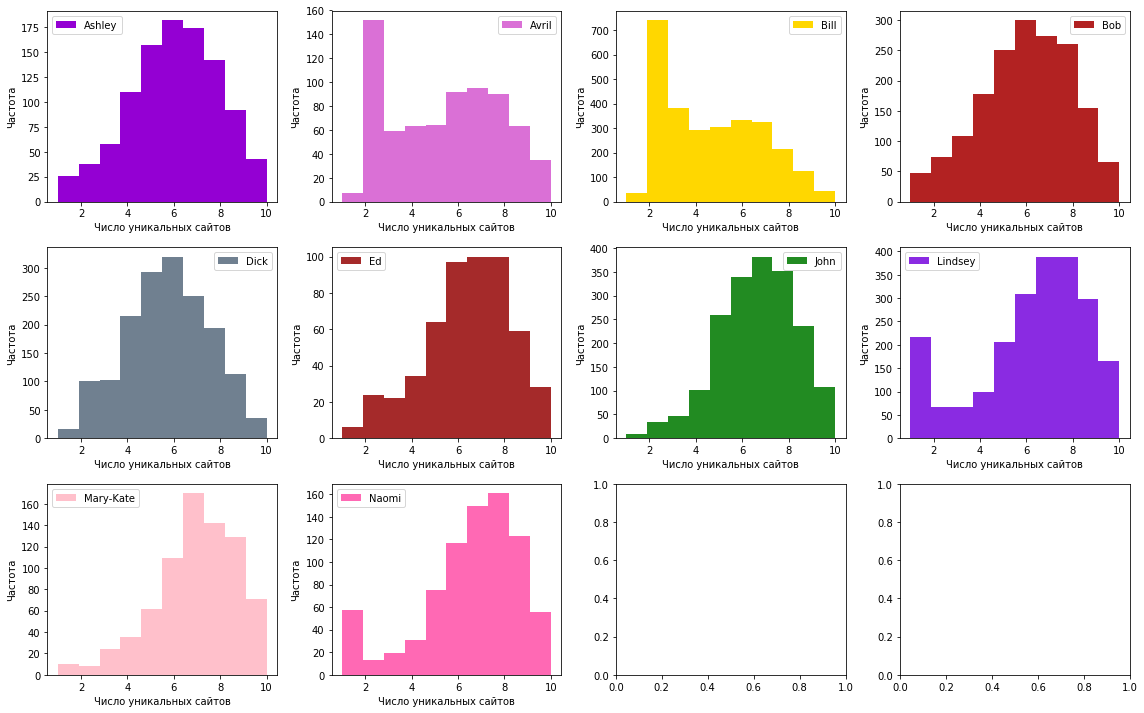

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[idx // 4, idx % 4]
    pd.Series(sub_df['#unique_sites'], name=user).plot(ax=ax, kind='hist', color=color_dic[user], legend=True)
    ax.set_ylabel('Частота')
    ax.set_xlabel('Число уникальных сайтов')
fig.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0.5,0,'Час начала сессии')

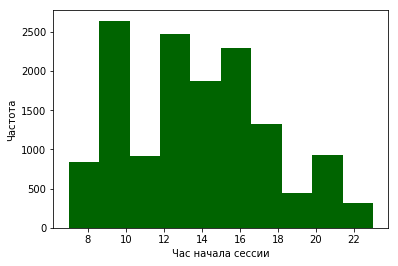

In [22]:
train_data_10users['start_hour'].plot(kind='hist', color='darkgreen')
plt.ylabel('Частота')
plt.xlabel('Час начала сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

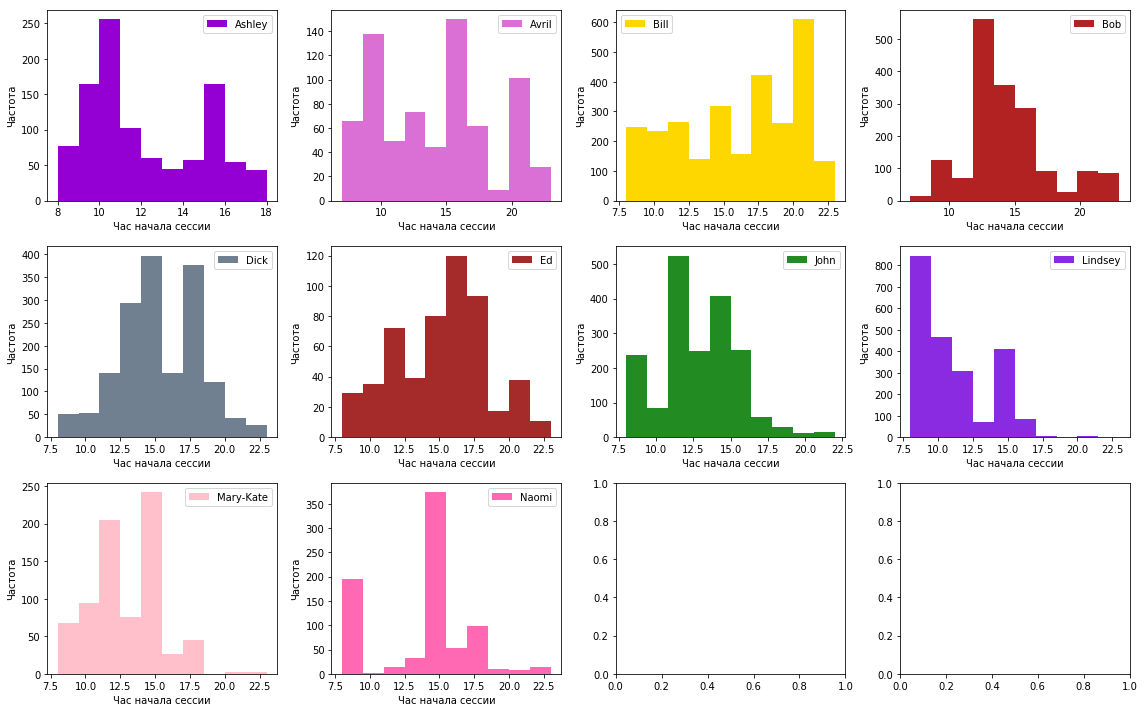

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[idx // 4, idx % 4]
    pd.Series(sub_df['start_hour'], name=user).plot(ax=ax, kind='hist', color=color_dic[user], legend=True)
    ax.set_ylabel('Частота')
    ax.set_xlabel('Час начала сессии')
fig.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

([<matplotlib.axis.XTick at 0x7f5c62ffbc50>,
 <a list of 7 Text xticklabel objects>)

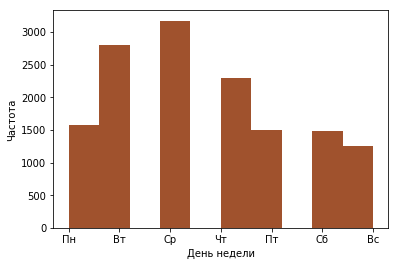

In [24]:
train_data_10users['day_of_week'].plot(kind='hist', color='sienna')
plt.ylabel('Частота')
plt.xlabel('День недели')
plt.xticks(np.arange(7), ('Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'))

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

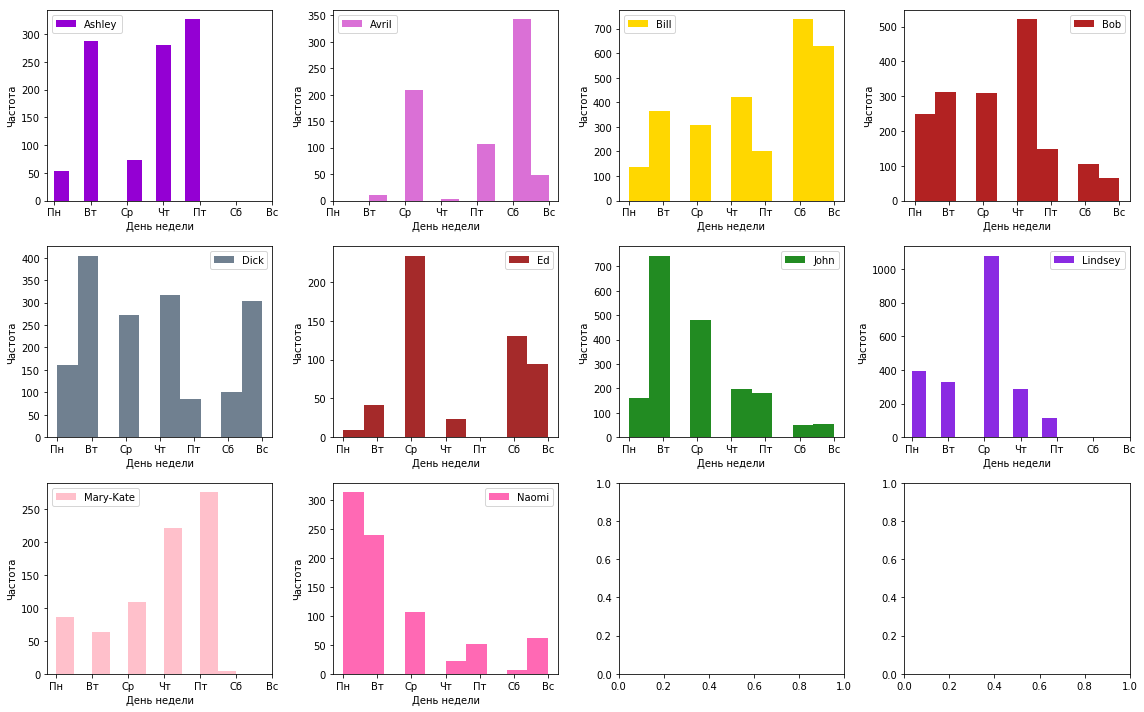

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    ax = axes[idx // 4, idx % 4]
    pd.Series(sub_df['day_of_week'], name=user).plot(ax=ax, kind='hist', color=color_dic[user], legend=True)
    ax.set_ylabel('Частота')
    ax.set_xlabel('День недели')
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
fig.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

1) Ashley
Число уникальных сайтов в сессии из 10 сайтов имеет распределение близкое к нормальному, но смещенное вправо к 10 уникальным сайтам, чаще всего посещает около 6-7 уникальных сайтов за сессию.
Начинает сессии посещения сайтов в основном в 11:00 и в 15:00 часов.
Посещает сайты только по будням, в основном во вторник, четверг и пятницу.

2) Avril
Наблюдается много сессий с двумя уникальными сайтами, а также с 6-8 уникальными сайтами.
Начинает сессии поссещения сайтов в 9-10 утра, в 16:00, а также в 21:00.
Сайты посещает в среду и во второй половине недели, больше всего в субботу.

3) Bill
Наблюдается много сессий с двумя уникальными сайтами, сессии с 3-7 уникальными сайтами повторяются примерно одинаковое количество раз.
Стабильно посещает сессии утром с 8 до 12 часов, в 15:00 и в 17:30, но больше всего в 21:00.
больше всего посещает сайты по выходным.
Посещает сайты всю неделю, но больше всего в выходные.

4) Bob
Число уникальных сайтов в сессиях похоже на нормальное распределение, но смещенное вправо к 10 уникальным сайтам, пик приходится на 6 уникальных сайтов в сессии.
Посещает сессии в основном в середине дня с 12 до 15 часов, чаще всего начинает в 12:00 часов.
В будни посещает сайтов больше, чем в выходные пик приходится на чатверг.

5) Dick
Число уникальных сайтов в сессиях похоже на нормальное распределение, пик приходится на 6 уникальных сайтов в сессии.
Посещает сессии в основном в середине дня с 12 до 15 часов, а так же в 17:30.
Посещает сайты всю неделю в основнов во вторник, реже в среду, четверг и воскресенье.

6) Ed
Число уникальных сайтов в сессиях похоже на нормальное распределение, но смещенное в право к 10 уникальным сайтам, пик приходится на 7-8 уникальных сайтов в сессии.
Активно посещает сайты с 8:00 до 18:00 пик приходится на 16:00, а также вечером в 21:00.
Посещает сайты в основном в среду и в оба выходных.

7) John
Пик распределения числа уникальных сайтов приходится на 7 уникальных сайтов из 10, распределение похоже на нормальное, но смещенное в право к 10 уникальным сайтам.
Активно посещает сессии утром с 8 до 9 часов и в середине дня с 12 до 16 часов, пик приходится на 12 часов, вечером почти не посещает сайты. 
Посещает сайты всю неделю больше всего во вторник и среду.

8) Lindsey
Распределение числа уникальных сайтов имеет два пика, второй относится к смещенному нормальному распределению с пиклм в 7 уникальных сайтов. А первый пик приходится на 1 уникальный сайт в сессии из 10 посещений.
Активно посещает сессии в первой половине дня с 8 до 12 часов, с пиков в 8 часов утра. И в 15:00.
Посещает сайты только по будням, больше всего в среду.

9) Mary-Kate
Пик распределения числа уникальных сайтов приходится на 7 уникальных сайтов из 10.
Посещает сайты до 18:00. Чаще всего в 11 и 14 часов.
Посещает сайты в будни преимущественно в пятницу и четверг.

10) Naomi
Пик распределения числа уникальных сайтов в сессиях приходится на 8 сайтов из 10. Однако наблюдается небольшой пик и на 1 уникальном сайте в сессии.
Начинает сессии чаще всего в 14:00 и в 8:00.
Сайты посещает в течении всей недели, но в основном в понедельник и вторник.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [26]:
with open ('site_freq_10users.pkl', 'rb') as f:
    site_freq_10users = pickle.load(f)

In [27]:
site_freq_10users

{'fpdownload2.macromedia.com': (193, 88),
 'laposte.net': (587, 23),
 'www.laposte.net': (134, 119),
 'www.google.com': (3, 5441),
 'match.rtbidder.net': (204, 84),
 'x2.vindicosuite.com': (425, 37),
 'rp.gwallet.com': (192, 88),
 'pool-eu-ie.creative-serving.com': (706, 18),
 'dl.javafx.com': (257, 65),
 'ajax.googleapis.com': (31, 711),
 'api.dailymotion.com': (401, 40),
 'i1-js-14-3-01-11074-266576264-i.init.cedexis-radar.net': (4913, 1),
 'limelight.cedexis.com': (221, 78),
 'webmail.laposte.net': (55, 399),
 'www.facebook.com': (5, 4141),
 'rubicon-match.dotomi.com': (295, 55),
 'pr.ybp.yahoo.com': (341, 47),
 'dtm.ccs.com': (936, 12),
 'b12.myspace.com': (486, 31),
 'i1-js-14-3-01-11074-845302217-i.init.cedexis-radar.net': (4912, 1),
 'trk.adbutter.net': (1006, 11),
 'rs.mediapostcommunication.net': (202, 85),
 'av.mediapostcommunication.net': (124, 133),
 'rbp.mxptint.net': (349, 46),
 'i1-js-14-3-01-11074-25651477-i.init.cedexis-radar.net': (4911, 1),
 'level3.cedexis.com': (26

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [28]:
top10_sites = sorted(site_freq_10users, key = site_freq_10users.get)[:10]
top10_freqs = [site_freq_10users[site][1] for site in top10_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

[Text(0,0,'s.youtube.com'),
 Text(0,0,'www.google.fr'),
 Text(0,0,'www.google.com'),
 Text(0,0,'mail.google.com'),
 Text(0,0,'www.facebook.com'),
 Text(0,0,'apis.google.com'),
 Text(0,0,'r3---sn-gxo5uxg-jqbe.googlevideo.com'),
 Text(0,0,'r1---sn-gxo5uxg-jqbe.googlevideo.com'),
 Text(0,0,'plus.google.com'),
 Text(0,0,'accounts.google.com')]

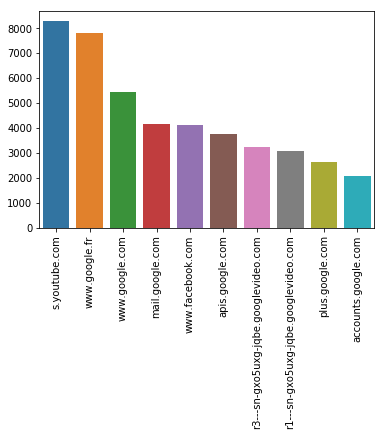

In [29]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [56]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10, window_size=10, flag_old=True):
    if window_size < 1 or window_size > session_length:
        ValueError()
    else:
        file_list = sorted(glob(os.path.join(path_to_csv_files,'*.csv')))
        with open(site_freq_path, 'rb') as f:
            site_freq_dict = pickle.load(f)


        file_data = {}
        user_data = {}
        for user_id, file_name in enumerate(file_list):
            data = pd.read_csv(file_name)
            data.timestamp = pd.to_datetime(data.timestamp)
            months = np.array(data.timestamp.dt.month, dtype=np.int64)
            hours = np.array(data.timestamp.dt.hour, dtype=np.int64)
            daysofweek = np.array(data.timestamp.dt.dayofweek, dtype=np.int64)
            all_time_diff = [int(pd.Timedelta(d2 - d1).seconds) for d1, d2 in zip(data.timestamp[:- 1], data.timestamp[1:])]
            site_id = np.array([site_freq_dict[site][0] for site in data.site])
            if window_size:
                axis0 = whole = len(site_id) // window_size
                rest = len(site_id) % window_size
                if rest:
                    axis0 += 1
                file_data[user_id] = np.zeros((axis0, len(features)), dtype=np.int64)
                for i, shift in enumerate(range(0, len(site_id), window_size)):
                    if shift + session_length <= len(site_id):
                        site_in_session = list(site_id[shift:(shift + session_length)])
                        seq = site_in_session
                        if flag_old:
                            time_diff = all_time_diff[shift:(shift + session_length) - 1]
                            hour = hours[shift:(shift + session_length)].min()
                            dayofweek = daysofweek[shift:(shift + session_length)].min()
                            seq.extend(time_diff + [sum(time_diff)] + [len(np.unique(site_in_session))] + [hour] + [dayofweek])
                        seq.extend([months[shift:(shift + session_length)].min()])
                        file_data[user_id][i] = seq + [user_id + 1]
                    else:
                        file_data[user_id][i][:rest] = site_id[shift:]
                        if flag_old:
                            time_diff = all_time_diff[shift:]
                            file_data[user_id][i][session_length :(session_length + rest - 1)] = time_diff
                            file_data[user_id][i][2 * session_length - 1: 2 * session_length + 3] = [sum(time_diff)] + [len(np.unique(site_id[shift:]))] + [hours[shift:].min()] + [daysofweek[shift:].min()]
                        
                        file_data[user_id][i][-2:] = [months[shift:].min()] + [user_id + 1]
        
        file_len = len(file_list) - 1
        for i in range(file_len):
            file_data[i + 1] = np.vstack((file_data[i], file_data[i + 1]))
            
        user_data = pd.DataFrame(file_data[file_len], columns=features, index=range(1, file_data[file_len].shape[0] + 1))
        user_data.index.name = 'session_id'

        return user_data

In [61]:
features = ['site' + str(i) for i in range(1,11)] + ['start_month', 'target']
train_data_toy  = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  features=features, session_length=10, flag_old=False)

In [62]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,start_month,target
session_id,,,,,,,,,,,,
1,4,2,2,11,2,1,10,6,9,8,11,1
2,4,1,1,1,0,0,0,0,0,0,11,1
3,4,2,5,5,2,0,0,0,0,0,11,2
4,3,1,2,1,2,1,1,6,7,3,11,3
5,3,1,2,0,0,0,0,0,0,0,11,3


In [90]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  features=features, session_length=10, flag_old=False)

In [91]:
new_features_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,start_month,target
session_id,,,,,,,,,,,,
1,193,587,134,3,134,134,3,134,204,134,11,1
2,425,192,706,257,134,31,401,4913,221,55,11,1
3,55,3,55,55,5,295,425,341,936,55,11,1
4,486,4912,486,55,55,55,55,1006,202,124,11,1
5,349,55,5,4911,261,212,4910,2574,705,2574,11,1
6,231,705,212,212,55,55,128,174,4909,4908,11,1
7,358,587,134,3,134,31,134,401,193,134,11,1
8,264,4907,1778,401,55,3,55,3,202,124,11,1
9,55,341,106,204,1372,533,55,850,106,5,11,1


In [65]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  features=features, session_length=10, flag_old=False)

In [66]:
new_features_150users 

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,start_month,target
session_id,,,,,,,,,,,,
1,1,1,4,2,1,4,1,2,1298,322,11,1
2,2,23,1518,1298,322,322,113,73,49,49,11,1
3,322,205,1,1,1,1,73,322,2,1,11,1
4,1,1,7574,7574,5825,7574,7574,1,35,1,11,1
5,1,1,76,1,58,50,58,50,83,76,11,1
6,50,58,94,92,50,76,76,83,92,50,11,1
7,58,94,58,92,76,83,50,94,94,76,11,1
8,83,50,58,92,58,94,50,50,76,58,11,1
9,94,76,83,50,92,58,7574,76,50,58,11,1


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [97]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [99]:
pd.groupby(new_features_10users, 'target')

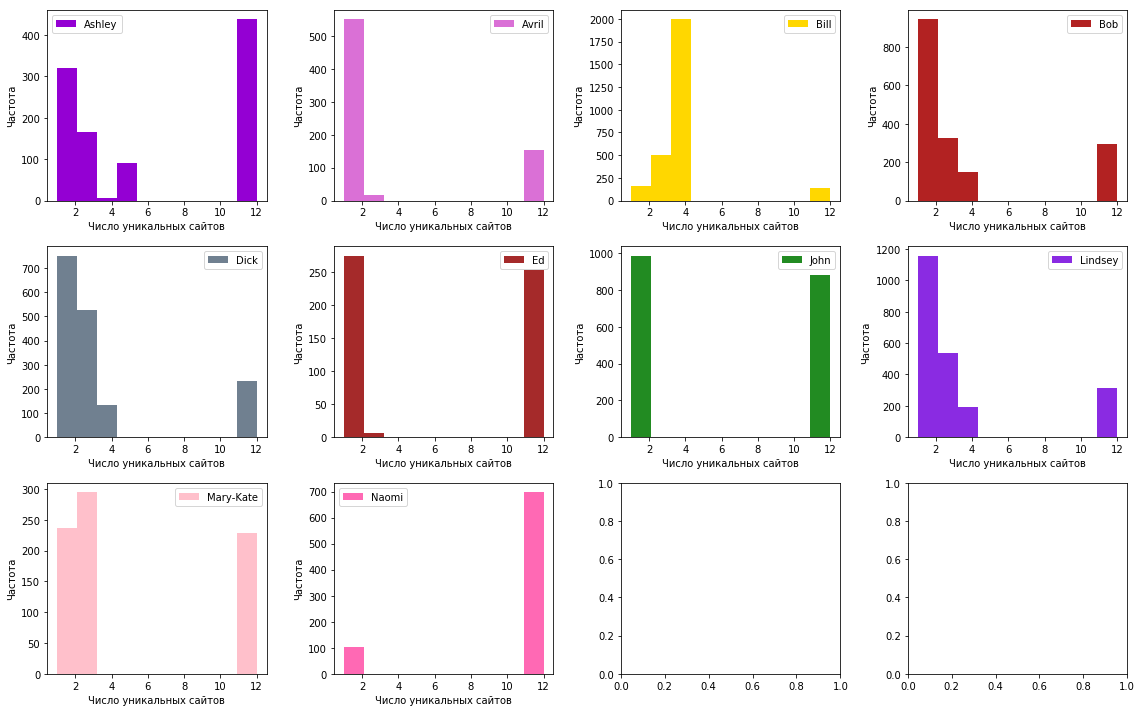

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(pd.groupby(new_features_10users, 'target')): 
    ax = axes[idx // 4, idx % 4]
    pd.Series(sub_df['start_month'], name=user).plot(ax=ax, kind='hist', color=color_dic[user], legend=True)
    ax.set_ylabel('Частота')
    ax.set_xlabel('Число уникальных сайтов')
fig.tight_layout()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 